In [36]:
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
import seaborn as sns
!pip install kmodes
from kmodes.kmodes import KModes
from datetime import datetime

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
dataset = pd.read_csv('C:/Users/marci/Documents/NCI/ML/cardio_train.csv', sep=';')
pd.set_option('display.max_columns', None)
print(dataset.count().unique())
dataset.head()

[70000]


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [38]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [39]:
# checking for missing values
print(dataset.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [40]:
# droping id column
dataset = dataset.drop('id', axis=1)

In [41]:
dataset.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Removing outliers, , we can see that max/low height, weight, ap_hi and ap_lo are looks like out of bounds, we will remove everything that is outside of range of 3% to 97% 
dataset.drop(dataset[(dataset['height'] > dataset['height'].quantile(0.97)) | (dataset['height'] < dataset['height'].quantile(0.03))].index,inplace=True)
dataset.drop(dataset[(dataset['weight'] > dataset['weight'].quantile(0.97)) | (dataset['weight'] < dataset['weight'].quantile(0.03))].index,inplace=True)
dataset.drop(dataset[(dataset['ap_hi'] > dataset['ap_hi'].quantile(0.97)) | (dataset['ap_hi'] < dataset['ap_hi'].quantile(0.03))].index,inplace=True)
dataset.drop(dataset[(dataset['ap_lo'] > dataset['ap_lo'].quantile(0.97)) | (dataset['ap_lo'] < dataset['ap_lo'].quantile(0.03))].index,inplace=True)
len(dataset)

57828

In [43]:
# converting age from days to years
dataset['age'] = (dataset['age'] / 365).round().astype('int')

print(dataset.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       2     168    62.0    110     80            1     1      0     0   
1   55       1     156    85.0    140     90            3     1      0     0   
2   52       1     165    64.0    130     70            3     1      0     0   
3   48       2     169    82.0    150    100            1     1      0     0   
5   60       1     151    67.0    120     80            2     2      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
5       0       0  


In [44]:
# doing label encoder
label_encoder = preprocessing.LabelEncoder()
dataset = dataset.apply(label_encoder.fit_transform)
dataset.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000,57828.000000
mean,15.400948,0.350194,14.620340,76.411548,26.236425,15.682334,0.354119,0.221605,0.085581,0.051947,0.803676,0.494864
std,6.722574,0.477035,6.821789,39.424559,13.544854,7.505061,0.673139,0.569349,0.279747,0.221922,0.397220,0.499978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,10.000000,45.000000,20.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,16.000000,0.000000,15.000000,76.000000,20.000000,14.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,20.000000,1.000000,20.000000,107.000000,40.000000,24.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,27.000000,1.000000,30.000000,153.000000,60.000000,34.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
# splitting data
x = dataset.drop(['cardio'], axis=1)
y = dataset['cardio']

x.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,12,1,18,29,10,14,0,0,0,0,1
1,17,0,6,122,40,24,2,0,0,0,1
2,14,0,15,39,30,4,2,0,0,0,0
3,10,1,19,109,50,34,0,0,0,0,1
5,22,0,1,52,20,14,1,1,0,0,0


In [46]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.20, random_state=1)

Sklearn Precision =  0.758016331408086
Duration: 0:00:01.397059
R2 score: -0.132581218469898
Accuracy Random Forest: 72.18


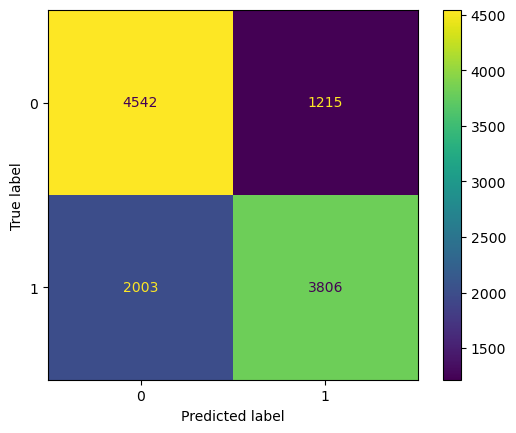

In [47]:
# Random Forest
def RandomForest_fun():
    start_time = datetime.now()
    RandomForestModel = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, min_samples_leaf=1, random_state=1)
    RandomForestModel.fit(x_train, y_train)
    RandomForestModel_pred = RandomForestModel.predict(x_test)
    RandomForestModel_accuracy = metrics.accuracy_score(y_test, RandomForestModel_pred)*100
    end_time = datetime.now()
    cm = confusion_matrix(y_test, RandomForestModel_pred, labels= RandomForestModel.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RandomForestModel.classes_)
    disp.plot()
    sklearn_precision = precision_score(y_test,RandomForestModel_pred)
    print("Sklearn Precision = ",sklearn_precision)
    print('Duration: {}'.format(end_time - start_time))
    print("R2 score: {0}".format(r2_score(RandomForestModel_pred, y_test)))
    return print(f"Accuracy Random Forest: {RandomForestModel_accuracy:.2f}")
    
    
RandomForest_fun()

Sklearn Precision =  0.7480750246791708
Duration: 0:00:00.214936
R2 score: -0.157739298365974
Accuracy Logistic Regresion: 71.50


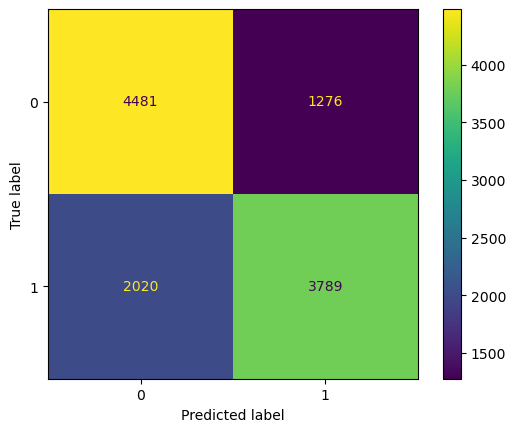

In [48]:
# Logistic Regression
def LogisticRegresion_fun():
    start_time = datetime.now()
    LogisticRegresionModel = LogisticRegression(max_iter = 1000)
    LogisticRegresionModel.fit(x_train, y_train)
    LogisticRegresionModel_pred = LogisticRegresionModel.predict(x_test)
    LogisticRegresionModel_accuracy = metrics.accuracy_score(y_test, LogisticRegresionModel_pred)*100
    end_time = datetime.now()
    cm = confusion_matrix(y_test, LogisticRegresionModel_pred, labels= LogisticRegresionModel.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogisticRegresionModel.classes_)
    disp.plot()
    sklearn_precision = precision_score(y_test,LogisticRegresionModel_pred)
    print("Sklearn Precision = ",sklearn_precision)
    print('Duration: {}'.format(end_time - start_time))
    print("R2 score: {0}".format(r2_score(LogisticRegresionModel_pred, y_test)))
    return print(f"Accuracy Logistic Regresion: {LogisticRegresionModel_accuracy:.2f}")
    
    
LogisticRegresion_fun()

Sklearn Precision =  0.687099725526075
Duration: 0:00:00.447617
R2 score: -0.3056946103806415
Accuracy KNeighbors: 67.46


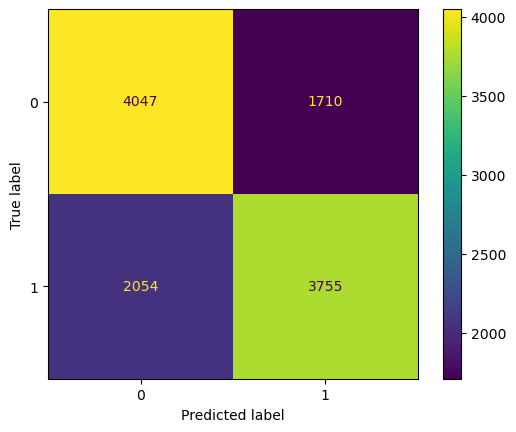

In [49]:
# KNeighbors
def KNeighbors_fun():
    start_time = datetime.now()
    KNeighborsModel = KNeighborsClassifier()
    KNeighborsModel.fit(x_train, y_train)
    KNeighborsModel_pred = KNeighborsModel.predict(x_test)
    KNeighborsModel_accuracy = metrics.accuracy_score(y_test, KNeighborsModel_pred)*100
    end_time = datetime.now()
    cm = confusion_matrix(y_test, KNeighborsModel_pred, labels= KNeighborsModel.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=KNeighborsModel.classes_)
    disp.plot()
    sklearn_precision = precision_score(y_test,KNeighborsModel_pred)
    print("Sklearn Precision = ",sklearn_precision)
    print('Duration: {}'.format(end_time - start_time))
    print("R2 score: {0}".format(r2_score(KNeighborsModel_pred, y_test)))
    return print(f"Accuracy KNeighbors: {KNeighborsModel_accuracy:.2f}")
    
    
KNeighbors_fun()